In [1]:
# data manipulation
import pandas as pd
import numpy as np

# pre processing
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# model
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklvq import GMLVQ as BaseGMLVQ

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# saving
import joblib

In [2]:
X_train = joblib.load('../data/X_train.pkl')
y_train = joblib.load('../data/y_train.pkl')

X_train.shape, y_train.shape

((36249, 18), (36249,))

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
scoring = {
    'accuracy': 'accuracy',
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_macro': make_scorer(f1_score, average='macro')
}

In [5]:
class CustomGMLVQ(BaseGMLVQ):
    def predict(self, X):
        decision_values = self.decision_function(X)
        
        if self.classes_.size == 2:
            return self.classes_[(decision_values > 0).astype(np.int64)]  # Changed from np.int to np.int64
        
        return self.classes_[decision_values.argmax(axis=1)]

In [6]:
model = CustomGMLVQ(random_state=42)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [9]:
param_grid = [
    {
        "solver_type": ["steepest-gradient-descent", "waypoint-gradient-descent"],
        "distance_type": ["adaptive-squared-euclidean"],
        "activation_type": ["identity"],
        "solver_params": [{"step_size": s} for s in [0.1, 0.01, 0.001]]
    },
    {
        "solver_type": ["steepest-gradient-descent", "waypoint-gradient-descent"],
        "distance_type": ["adaptive-squared-euclidean"],
        "activation_type": ["sigmoid"],
        "activation_params": [{"beta": b} for b in [1, 2, 3]],
        "solver_params": [{"step_size": s} for s in [0.1, 0.01, 0.001]]
    }
]

In [10]:
pipeline_param_grid = [
    {
        "lvq__solver_type": ["steepest-gradient-descent", "waypoint-gradient-descent"],
        "lvq__distance_type": ["adaptive-squared-euclidean"],
        "lvq__activation_type": ["identity"],
        "lvq__solver_params": [{"step_size": s} for s in [0.1, 0.01, 0.001]]
    },
    {
        "lvq__solver_type": ["steepest-gradient-descent", "waypoint-gradient-descent"],
        "lvq__distance_type": ["adaptive-squared-euclidean"],
        "lvq__activation_type": ["sigmoid"],
        "lvq__activation_params": [{"beta": b} for b in [1, 2, 3]],
        "lvq__solver_params": [{"step_size": s} for s in [0.1, 0.01, 0.001]]
    }
]

In [11]:
def train_random_search(X, y, estimator, grid, n_iter=20):
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=grid,
        cv=skf,
        scoring=scoring,
        refit='f1_macro',
        n_jobs=-1,
        return_train_score=True,
        verbose=0,
        n_iter=n_iter
    )

    random_search.fit(X, y)

    return random_search

In [12]:
def get_results(r_search, pipeline=False):
    results = pd.DataFrame(r_search.cv_results_)
    
    if pipeline:
        results = results[
            [
                'mean_fit_time', 'mean_score_time', 'param_lvq__solver_type', 'param_lvq__distance_type', 'param_lvq__activation_type', 'param_lvq__solver_params',
                'param_lvq__activation_params', 'mean_train_accuracy', 
                'mean_test_accuracy', 'rank_test_accuracy', 
                'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
                'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
            ]
        ]
    else:
        results = results[
            [
                'mean_fit_time', 'mean_score_time', 'param_solver_type', 'param_distance_type', 'param_activation_type', 'param_solver_params', 'param_activation_params','mean_train_accuracy', 'mean_test_accuracy', 'rank_test_accuracy', 
                'mean_train_precision_macro', 'mean_test_precision_macro', 'rank_test_precision_macro', 'mean_train_recall_macro', 
                'mean_test_recall_macro', 'rank_test_recall_macro', 'mean_train_f1_macro', 'mean_test_f1_macro', 'rank_test_f1_macro'
            ]
        ]


    results = results.sort_values(by='mean_test_f1_macro', ascending=False)
    return results

In [14]:
rs = train_random_search(X_train, y_train, model, param_grid)

In [15]:
results = get_results(rs)
results.head()

,mean_fit_time,mean_score_time,param_solver_type,param_distance_type,param_activation_type,param_solver_params,param_activation_params,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
5,142.026903,0.016600,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'step_size': 0.001},{'beta': 2},0.813089,0.813043,1,0.817789,0.817915,1,0.800045,0.800169,1,0.804423,0.804424,1
18,137.930479,0.012566,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'step_size': 0.001},{'beta': 3},0.805659,0.807250,2,0.813039,0.814343,3,0.791135,0.793261,2,0.795810,0.797758,2
3,141.506553,0.016200,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'step_size': 0.001},{'beta': 1},0.805837,0.804630,3,0.818940,0.817556,2,0.787004,0.785880,3,0.792772,0.791600,3
4,136.408007,0.016700,steepest-gradient-descent,adaptive-squared-euclidean,identity,{'step_size': 0.001},NaN,0.798020,0.797760,4,0.811601,0.811377,4,0.778718,0.778556,4,0.784373,0.784206,4
6,142.276781,0.016600,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'step_size': 0.01},{'beta': 2},0.773560,0.773070,10,0.793898,0.792765,10,0.750393,0.749868,5,0.755634,0.755142,5


In [25]:
def view_test_metrics(train_metrics: bool, filter_top_n: int, results_df: pd.DataFrame, pipeline: bool=False):
    if train_metrics:
        metrics = [
            "mean_train_accuracy", "mean_test_accuracy",
            "mean_train_precision_macro", "mean_test_precision_macro",
            "mean_train_recall_macro", "mean_test_recall_macro",
            "mean_train_f1_macro", "mean_test_f1_macro"
        ]
    else:
        metrics = [
            "mean_test_accuracy",
            "mean_test_precision_macro",
            "mean_test_recall_macro",
            "mean_test_f1_macro"
        ]

    if filter_top_n:
        results_df = results_df.nsmallest(filter_top_n, "rank_test_f1_macro")

    if pipeline:
        param_cols = [
            'param_lvq__solver_type', 'param_lvq__distance_type', 
            'param_lvq__activation_type', 'param_lvq__solver_params', 
            'param_lvq__activation_params'
        ]
    else:
        param_cols = [
            'param_solver_type', 'param_distance_type', 
            'param_activation_type', 'param_activation_params', 
            'param_solver_params',
        ]

    # Convert dictionary columns to strings to avoid unhashable type errors
    for col in param_cols:
        if col in results_df.columns:
            # Check if any entry in the column is a dictionary
            if results_df[col].apply(lambda x: isinstance(x, dict)).any():
                results_df[col] = results_df[col].apply(
                    lambda x: str(x) if isinstance(x, dict) else x
                )

    plot_df = results_df.melt(
        id_vars=param_cols,
        value_vars=metrics,
        var_name="metric",
        value_name="score"
    )

    plt.figure(figsize=(8, 8))
    
    # Group the data by parameter combination and create a list of groups.
    groups = list(plot_df.groupby(param_cols))
    # Create a color palette with as many colors as there are groups.
    colors = plt.cm.tab10(np.linspace(0, 1, len(groups)))
    
    for i, (combo, group) in enumerate(groups):
        group = group.sort_values("metric")
        # Create a label for the model using its parameters.
        label_str = ", ".join(f"{col}={val}" for col, val in zip(param_cols, combo))
        # Pick the color for this group.
        color = colors[i]
        
        # Separate training and test metrics
        train_group = group[group["metric"].str.startswith("mean_train")]
        test_group = group[~group["metric"].str.startswith("mean_train")]
        
        # Plot training metrics with the same color
        if not train_group.empty:
            plt.plot(train_group["metric"], train_group["score"], 
                     marker='x', linestyle='dashed', alpha=0.7,
                     color=color,
                     label=label_str + " (train)")
        # Plot test metrics with the same color
        if not test_group.empty:
            plt.plot(test_group["metric"], test_group["score"], 
                     marker='o', linestyle='solid', alpha=0.7,
                     color=color,
                     label=label_str + " (test)")

    plt.xlabel("Metric")
    plt.ylabel("Score")
    plt.title("Comparison of Mean Test Metrics")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

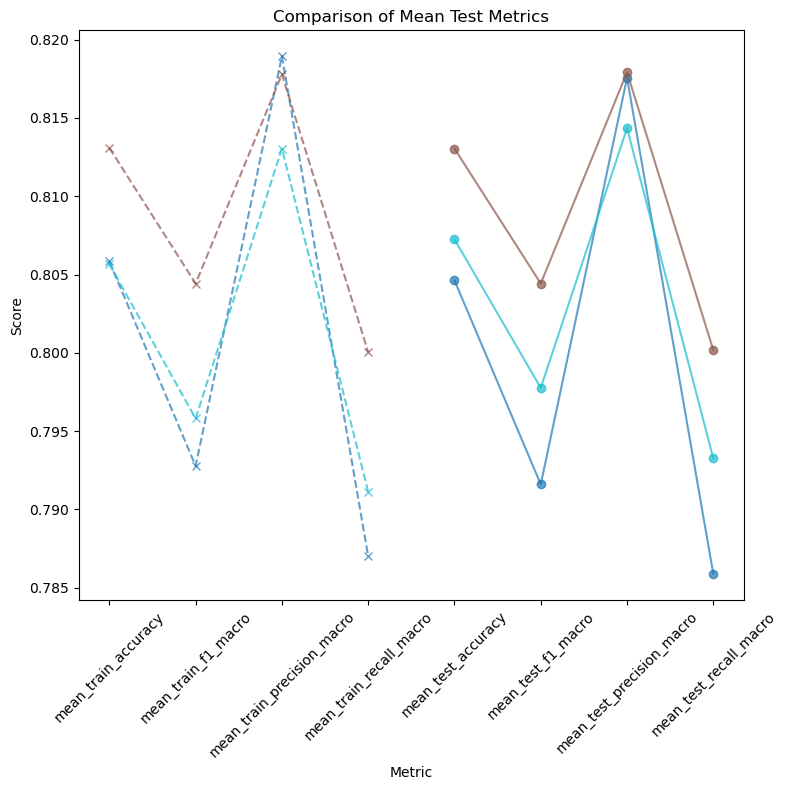

In [26]:
view_test_metrics(True, 3, results)

In [27]:
col_names = joblib.load('../data/cols.pkl')

In [42]:
col_names = col_names.drop('class')

In [43]:
col_names

Index(['date', 'period', 'month', 'is_weekend', 'nswprice', 'nswdemand',
       'vicprice', 'vicdemand', 'transfer', 'price_ratio', 'vic_class',
       'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday',
       'is_saturday', 'is_sunday'],
      dtype='object')

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_22244\2135747486.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


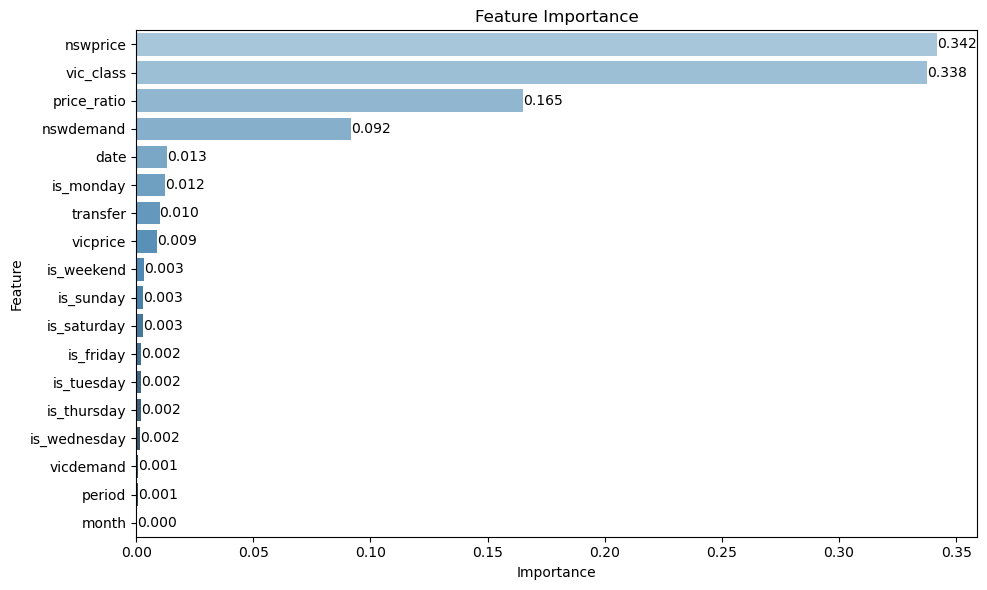

In [45]:
def feature_importance(model, feature_names):
    # Check if the model is a CustomGMLVQ and extract relevance
    if isinstance(model, CustomGMLVQ):
        if not hasattr(model, 'omega_'):
            raise ValueError("Model has not been fitted yet!")
        # Extract diagonal of the relevance matrix (Ω)
        importances = np.diag(model.omega_)
        # Normalize to sum to 1
        importances = np.abs(importances) / np.abs(importances).sum()
    else:
        # Fallback for models like RandomForest, XGBoost, etc.
        importances = model.feature_importances_

    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f')  # Format to 3 decimal places
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()

# Usage
feature_importance(rs.best_estimator_, feature_names=col_names)

### Testando balanceamento

In [32]:
ro_pipeline = Pipeline([
    ('oversampler', RandomOverSampler(sampling_strategy='auto', random_state=42)),
    ('lvq', CustomGMLVQ(random_state=42))
])

In [33]:
ro_rs = train_random_search(X_train, y_train, ro_pipeline, pipeline_param_grid, 20)

In [34]:
ro_results = get_results(ro_rs, True)
ro_results.head()

,mean_fit_time,mean_score_time,param_lvq__solver_type,param_lvq__distance_type,param_lvq__activation_type,param_lvq__solver_params,param_lvq__activation_params,mean_train_accuracy,mean_test_accuracy,rank_test_accuracy,mean_train_precision_macro,mean_test_precision_macro,rank_test_precision_macro,mean_train_recall_macro,mean_test_recall_macro,rank_test_recall_macro,mean_train_f1_macro,mean_test_f1_macro,rank_test_f1_macro
13,184.419970,0.019461,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'step_size': 0.001},{'beta': 1},0.820574,0.823306,1,0.818566,0.821391,1,0.814386,0.817103,1,0.815689,0.818461,1
3,176.707133,0.018908,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'step_size': 0.001},{'beta': 2},0.811532,0.814589,2,0.810586,0.813530,2,0.803470,0.806768,2,0.805603,0.808860,2
12,176.896890,0.018351,steepest-gradient-descent,adaptive-squared-euclidean,sigmoid,{'step_size': 0.01},{'beta': 1},0.773211,0.774229,7,0.776593,0.777462,7,0.763072,0.764049,3,0.764700,0.765669,3
0,8.811623,0.037169,waypoint-gradient-descent,adaptive-squared-euclidean,identity,{'step_size': 0.1},NaN,0.775139,0.775139,3,0.806665,0.806678,3,0.745530,0.745530,4,0.751453,0.751443,4
7,5.377866,0.028774,waypoint-gradient-descent,adaptive-squared-euclidean,sigmoid,{'step_size': 0.1},{'beta': 2},0.775139,0.775139,3,0.806665,0.806678,3,0.745530,0.745530,4,0.751453,0.751443,4


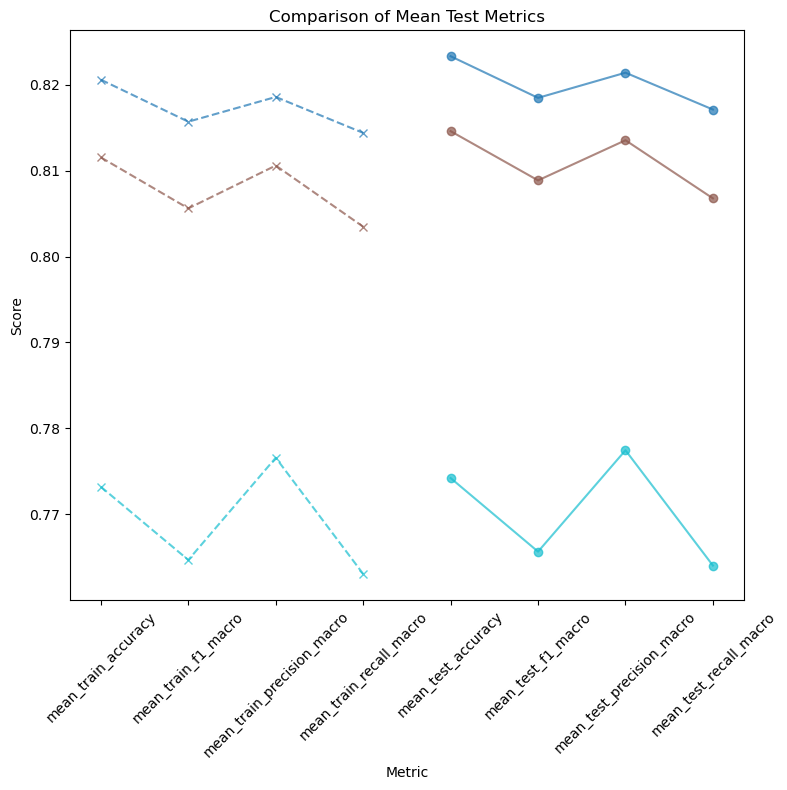

In [35]:
view_test_metrics(True, 3, ro_results, True)

Conseguimos melhorar as métricas com o random oversampling. Agora vamos calcular outras métricas para esse nosso melhor modelo.

C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_22244\2135747486.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette='Blues_d')


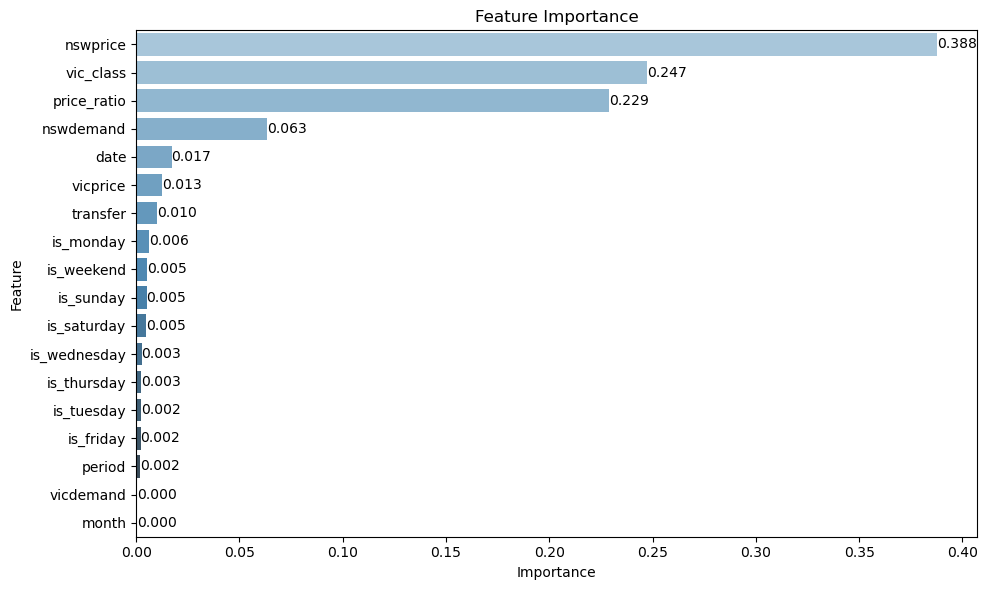

In [47]:
feature_importance(ro_rs.best_estimator_.named_steps['lvq'], feature_names=col_names)

In [48]:
preds = cross_val_predict(ro_rs.best_estimator_, X_train, y_train, cv=skf, n_jobs=-1)

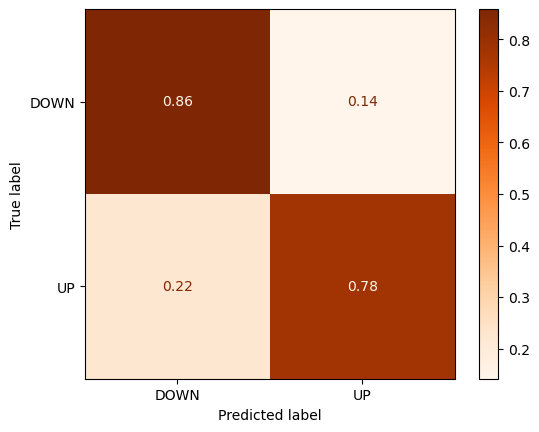

In [49]:
cm = confusion_matrix(y_train, preds, normalize='true')
cmd = ConfusionMatrixDisplay(cm, display_labels=['DOWN', 'UP'])
cmd.plot(cmap=plt.cm.Oranges)
plt.grid(False)
plt.show()

In [50]:
print(classification_report(y_train, preds, digits=4))

              precision    recall  f1-score   support

           0     0.8385    0.8582    0.8483     20860
           1     0.8015    0.7760    0.7885     15389

    accuracy                         0.8233     36249
   macro avg     0.8200    0.8171    0.8184     36249
weighted avg     0.8228    0.8233    0.8229     36249



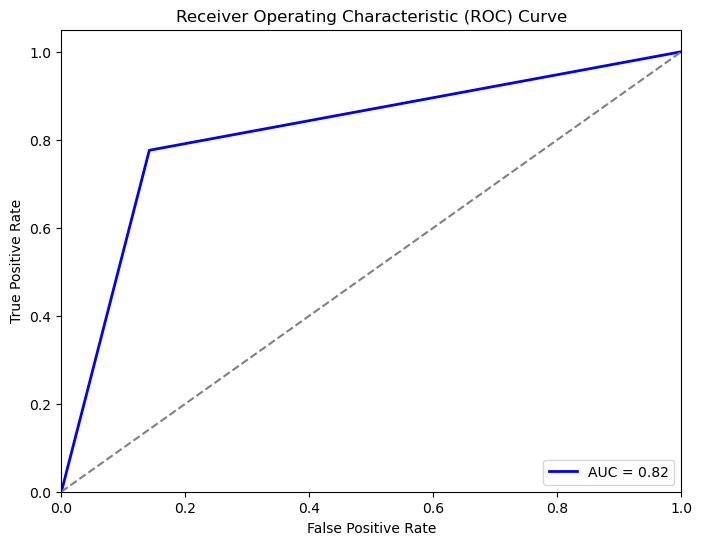

In [51]:
fpr, tpr, thresholds = roc_curve(y_train, preds)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [52]:
joblib.dump(ro_rs.best_estimator_.named_steps['lvq'], '../models/lvq.pkl')

['../models/lvq.pkl']